In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
def gen_sample(batch_size, N_agents, in_dim = None, L = None):
    """ 
        generates an inital states in [0,L1] x [0,L2] x ... x [0, Ln] of shape [Batch_size, in_dim]
    """
    #### Region with pdf > 0
    if in_dim is None and L is None:
        raise ValueError("Need either L or in dim to be set")
    if in_dim is None:
        in_dim = len(L)
    if L is None:
        L = [1. for _ in range(in_dim)]
    x = torch.rand(batch_size, N_agents, in_dim).abs()
    for i in range(len(L)):
        x[:, :, i] = torch.clamp(x[:, :, i],min = 0, max=L[i])
    return x


In [3]:
N_Agents = 1
in_dim = 2
batch_size = 256
n_samples = 2048
timesteps = 30
lam = 0.5
k_max = 7 ## will go up to 2^7 coefficients TODO implement
control_energy_reg = 0#1e-6 ### regularization on maximum control energy
u_max = 100 # does not do anything currently
thres = 0#1e-2 ### softness on constraint (will penalize when this much outside of rect)
dropout = 0


In [4]:
def custom_pdf(x):
    """
     Define a custom probability density function (PDF).
    """
    #x = x.item()
    #return np.where(((x > 0) & (x < 1)), 1, 0)
    return np.where(((x > 0) & (x < 0.3)) | ((x > 0.6) & (x < 0.9)), 5 / 3, 0)
    #return np.where((x > 0.6) & (x < 0.9),3, 0)

In [ ]:
from densities import uniform_rect_regions as pdf
import functools
region  = np.array([[[0, 0.3], [0, 0.3]],
                    [[0.6, 0.9], [0.7, 0.9]]])
custom_pdf = functools.partial(pdf, regions=region)

In [5]:
import Ergodic_Loss
import Recursive_KAN
import sys
sys.path.append(r'C:\Users\JP\Documents\TU Berlin\Master\Code_RNN\Recursive_kan\Ergodic_Loss.py') 
sys.path.append(r'C:\Users\JP\Documents\TU Berlin\Master\Code_RNN\Recursive_kan\Recursive_KAN.py') 
import importlib
importlib.reload(Ergodic_Loss)
importlib.reload(Recursive_KAN)
model = Recursive_KAN.KAN_RNN_Layer(N_Agents = N_Agents, in_dim = in_dim, hidden = 128, depth = 2, n_timesteps = timesteps,sys_param_lam= lam, u_max = u_max, network_type='multi', dropout = dropout)
model.init_hidden(batch_size = batch_size)
criterion = Ergodic_Loss.Ergodicity_Loss(N_Agents = N_Agents, n_timesteps = timesteps,L = None, in_dim = in_dim, k_max = (2**k_max) + 1, thres = thres, control_energy_reg = control_energy_reg, density = 'custom',verbose = False, pdf = custom_pdf, max_pdf = 3, num_samples = 100000)


KeyboardInterrupt: 

In [ ]:
def train(model, criterion, optimizer):
    train_loss = []
    model.train()  # Set the model to training mode
    iters = 0
    while True:
        iters += 1
        running_loss = 0.0 
        for samples in range(n_samples // batch_size):
            start_time = time.time()
            model.init_hidden(batch_size = batch_size)
            optimizer.zero_grad()
            outputs, control = model(gen_sample(batch_size = batch_size, N_agents = N_Agents, in_dim = in_dim))
            loss = criterion(x = outputs, u = control) + model.penalty #* 1e-2 ## punishment on leaving the rect
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / (n_samples // batch_size)
        if avg_loss < 0.01 or (iters > 500): ## by elastic net this is like 1e-2 in sup norm 
            print(iters, "number of iteration until convergence")
            break
        train_loss.append(avg_loss)
        print(f"Epoch [{iters}], Loss: {avg_loss:.6f}")
    plt.plot(train_loss)
    plt.title(f'train_loss uniform distribution with system dynamic x(k + 1) = x(k) + {lam} u, number of coefficients: {criterion.k_compare}')
    plt.legend()
    plt.show()
    print("Training Complete!")

In [ ]:
def train_higher_order(model, criterion, optimizer):
    train_loss = []
    model.train()  # Set the model to training mode
    iters = 0
    while True:
        iters += 1
        running_loss = 0.0 
        for samples in range(n_samples // batch_size):
            start_time = time.time()
            inputs = gen_sample(batch_size = batch_size, N_agents = N_Agents, in_dim = in_dim)
            def closure():
                model.init_hidden(batch_size = batch_size)
                optimizer.zero_grad()
                outputs, control = model(inputs)
                loss = criterion(x = outputs, u = control) + model.penalty
                loss.backward()
                return loss
                
            optimizer.step(closure)
            with torch.no_grad():
                model.init_hidden(batch_size = batch_size)
                control , outputs = model(gen_sample(batch_size = batch_size, N_agents = N_Agents, in_dim = in_dim))
                loss = criterion(x = outputs, u = control) + model.penalty
            running_loss += loss.item()
        avg_loss = running_loss / (n_samples // batch_size)
        train_loss.append(avg_loss)
        print(f"Epoch [{iters}], Loss: {avg_loss:.6f}")
        if avg_loss < 0.01 or (iters > 50): ## by elastic net this is like 1e-2 in sup norm 
            print(iters, "number of iteration until convergence")
            break
    plt.plot(train_loss)
    plt.title(f'train_loss uniform distribution with system dynamic x(k + 1) = x(k) + {lam} u')
    plt.legend()
    plt.show()
    print("Training Complete!")

Epoch [1], Loss: 0.155726
Epoch [2], Loss: 0.136818
Epoch [3], Loss: 0.069611
Epoch [4], Loss: 0.032492
Epoch [5], Loss: 0.016476
Epoch [6], Loss: 0.009882
Epoch [7], Loss: 0.009403
Epoch [8], Loss: 0.006621
Epoch [9], Loss: 0.004781
Epoch [10], Loss: 0.006600
Epoch [11], Loss: 0.004370
Epoch [12], Loss: 0.005528
Epoch [13], Loss: 0.007423
Epoch [14], Loss: 0.009782
Epoch [15], Loss: 0.012196
Epoch [16], Loss: 0.010385
Epoch [17], Loss: 0.011149
Epoch [18], Loss: 0.013630
Epoch [19], Loss: 0.007711
Epoch [20], Loss: 0.004458
Epoch [21], Loss: 0.007899
Epoch [22], Loss: 0.009149
Epoch [23], Loss: 0.013671
Epoch [24], Loss: 0.014150
Epoch [25], Loss: 0.021391
Epoch [26], Loss: 0.017836
Epoch [27], Loss: 0.012153
Epoch [28], Loss: 0.012133
Epoch [29], Loss: 0.010627
Epoch [30], Loss: 0.006507
Epoch [31], Loss: 0.008183
Epoch [32], Loss: 0.010517
Epoch [33], Loss: 0.008042
Epoch [34], Loss: 0.007951
Epoch [35], Loss: 0.013110
Epoch [36], Loss: 0.014878
Epoch [37], Loss: 0.005751
Epoch [38]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


51 number of iteration until convergence


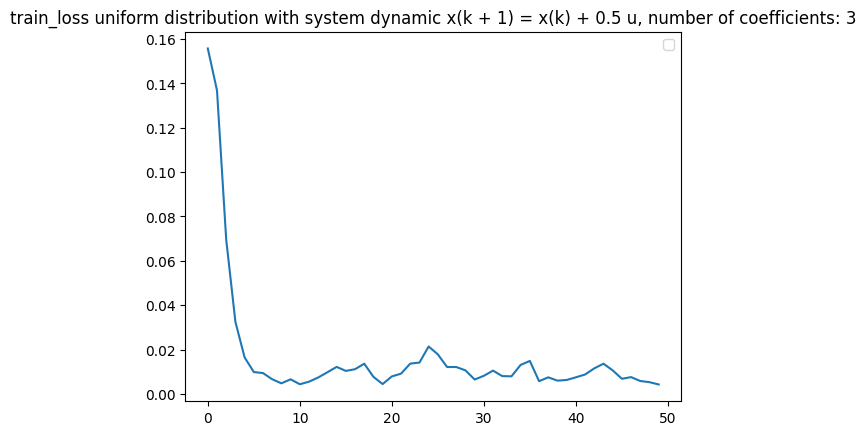

Training Complete!
Epoch [1], Loss: 0.029750
Epoch [2], Loss: 0.028119
Epoch [3], Loss: 0.027514
Epoch [4], Loss: 0.026877
Epoch [5], Loss: 0.026268
Epoch [6], Loss: 0.025822
Epoch [7], Loss: 0.025529
Epoch [8], Loss: 0.025043
Epoch [9], Loss: 0.025014
Epoch [10], Loss: 0.024921
Epoch [11], Loss: 0.024474
Epoch [12], Loss: 0.024554
Epoch [13], Loss: 0.024338
Epoch [14], Loss: 0.024025
Epoch [15], Loss: 0.023565
Epoch [16], Loss: 0.023433
Epoch [17], Loss: 0.023452
Epoch [18], Loss: 0.022819
Epoch [19], Loss: 0.022815
Epoch [20], Loss: 0.022420
Epoch [21], Loss: 0.022079
Epoch [22], Loss: 0.021891
Epoch [23], Loss: 0.021687
Epoch [24], Loss: 0.021440
Epoch [25], Loss: 0.021123
Epoch [26], Loss: 0.020840
Epoch [27], Loss: 0.020885
Epoch [28], Loss: 0.020801
Epoch [29], Loss: 0.020380
Epoch [30], Loss: 0.020295
Epoch [31], Loss: 0.020226
Epoch [32], Loss: 0.019695
Epoch [33], Loss: 0.019994
Epoch [34], Loss: 0.019791
Epoch [35], Loss: 0.019418
Epoch [36], Loss: 0.019206
Epoch [37], Loss: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


344 number of iteration until convergence


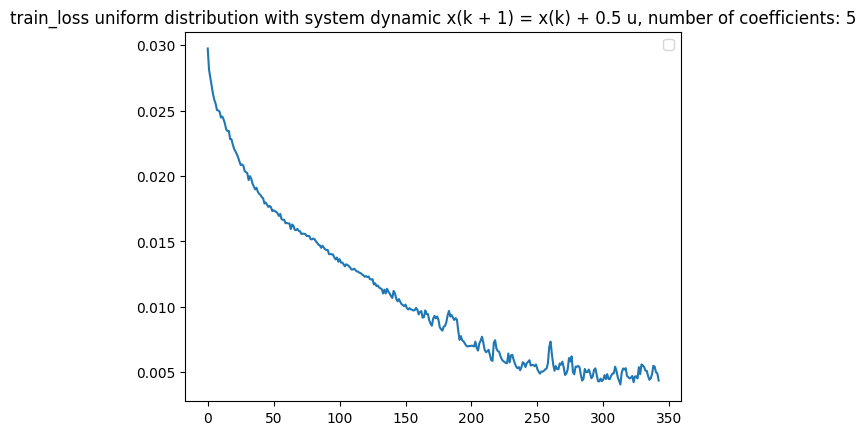

Training Complete!
Epoch [1], Loss: 0.013384
Epoch [2], Loss: 0.013140
Epoch [3], Loss: 0.013203
Epoch [4], Loss: 0.013091
Epoch [5], Loss: 0.013068
Epoch [6], Loss: 0.012924
Epoch [7], Loss: 0.012973
Epoch [8], Loss: 0.013057
Epoch [9], Loss: 0.012927
Epoch [10], Loss: 0.012965
Epoch [11], Loss: 0.012874
Epoch [12], Loss: 0.012804
Epoch [13], Loss: 0.012868
Epoch [14], Loss: 0.012824
Epoch [15], Loss: 0.012845
Epoch [16], Loss: 0.012816
Epoch [17], Loss: 0.012768
Epoch [18], Loss: 0.012791
Epoch [19], Loss: 0.012794
Epoch [20], Loss: 0.012673
Epoch [21], Loss: 0.012712
Epoch [22], Loss: 0.012738
Epoch [23], Loss: 0.012759
Epoch [24], Loss: 0.012686
Epoch [25], Loss: 0.012700
Epoch [26], Loss: 0.012773
Epoch [27], Loss: 0.012694
Epoch [28], Loss: 0.012709
Epoch [29], Loss: 0.012721
Epoch [30], Loss: 0.012687
Epoch [31], Loss: 0.012671
Epoch [32], Loss: 0.012657
Epoch [33], Loss: 0.012618
Epoch [34], Loss: 0.012672
Epoch [35], Loss: 0.012632
Epoch [36], Loss: 0.012598
Epoch [37], Loss: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


501 number of iteration until convergence


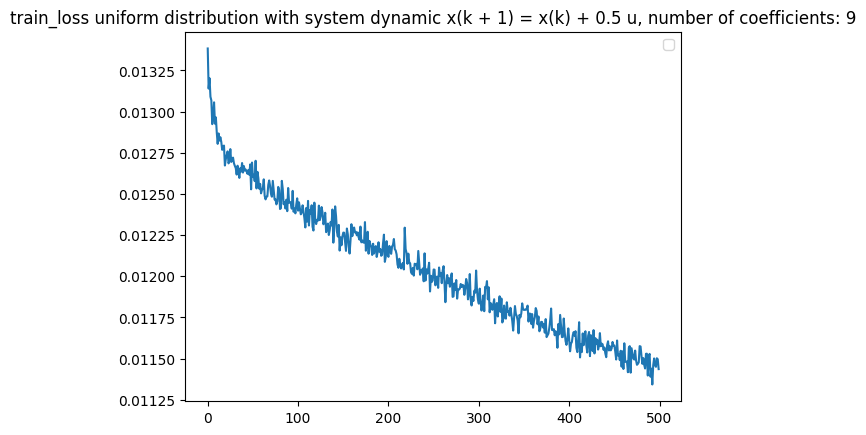

Training Complete!
Epoch [1], Loss: 0.809136
Epoch [2], Loss: 0.774510
Epoch [3], Loss: 0.753108
Epoch [4], Loss: 0.733010
Epoch [5], Loss: 0.727381
Epoch [6], Loss: 0.723717
Epoch [7], Loss: 0.722468
Epoch [8], Loss: 0.718321
Epoch [9], Loss: 0.719540
Epoch [10], Loss: 0.716575
Epoch [11], Loss: 0.718452


KeyboardInterrupt: 

In [ ]:
import time
for i in range(2,k_max + 1):
    criterion.k_compare = (2**i + 1) ## plus one because index 0 is always 1!
    print(criterion.k_compare)
    if (i == 5) or (i == 7):
        train_func = train
        optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
    elif (i == 23):
        train_func = train
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * 0.1 ### decrease learning rate with higher complexity
    elif (i == 123):
        break
        optimizer = optim.LBFGS(model.parameters(), line_search_fn = 'strong_wolfe') ### Careful steps when decrease on learning rate was dramatic!
        train_func = train_higher_order
    else:
        continue
    train_func(model, criterion, optimizer)

In [ ]:
criterion.verbose = True
inital_state = gen_sample(batch_size = 256, N_agents = N_Agents, in_dim = in_dim)
model.init_hidden(batch_size = 256)
outs, control = model(inital_state)
criterion(x = outs, u = control)

model: tensor(0.1251, grad_fn=<SelectBackward0>) target: tensor(0.1284)


tensor(0.0076, grad_fn=<AddBackward0>)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


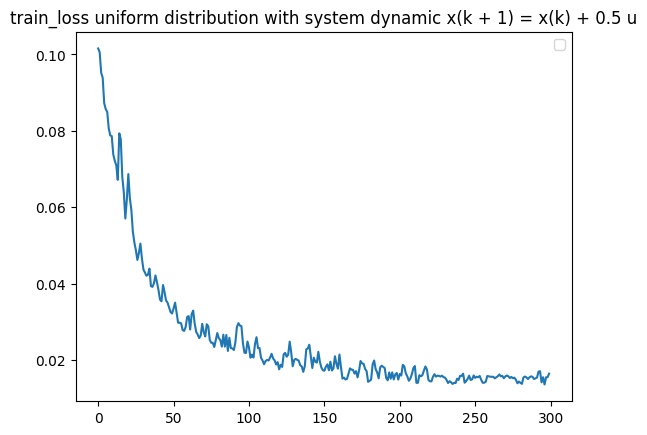

Training Complete!


In [ ]:
plt.plot(train_loss[-500:])
plt.title(f'train_loss uniform distribution with system dynamic x(k + 1) = x(k) + {lam} u')
plt.legend()
plt.show()
print("Training Complete!")

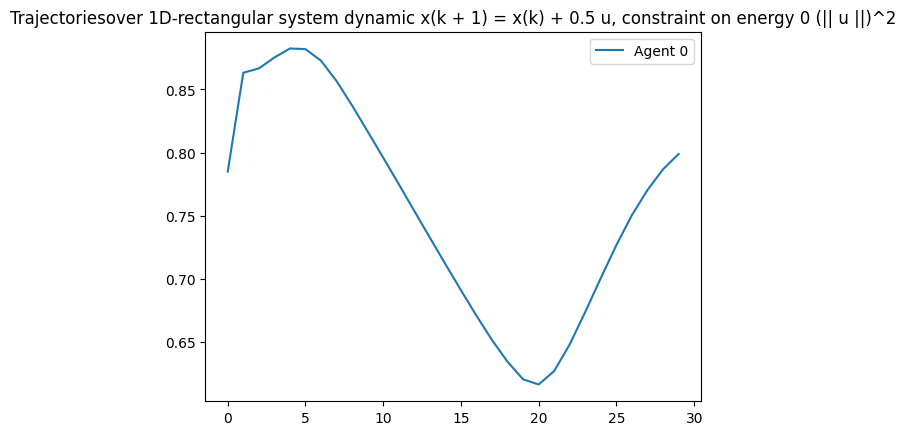

model: tensor(-0.9807, grad_fn=<SelectBackward0>) target: tensor(-0.9635)


tensor(0.0131, grad_fn=<AddBackward0>)

In [ ]:
#plot trajectory
#model.eval()
inital_state = gen_sample(batch_size = 1, N_agents = N_Agents, in_dim = in_dim)
model.init_hidden(batch_size = 1)
outs, control = model(inital_state)
for j in range(N_Agents):
    plt.plot(outs[:,:,j,:].squeeze().detach(), label = f'Agent {j}')
plt.title(f'Trajectoriesover 1D-rectangular system dynamic x(k + 1) = x(k) + {lam} u, constraint on energy {control_energy_reg} (|| u ||)^2')
plt.legend()
plt.show()
criterion(x = outs, u = control)

